In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import pandas as pd

## Policy Network

In [53]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, device):
        super(PolicyNetwork, self).__init__()
        self.device = device
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=-1)
        ).to(device)

    def forward(self, x):
        x = x.to(self.device)
        return self.network(x)

## Value Network

In [54]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, device):
        super(ValueNetwork, self).__init__()
        self.device = device
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(device)

    def forward(self, x):
        x = x.to(self.device)
        return self.network(x)

## PPO Agent

In [55]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, clip_ratio=0.2,
                 value_loss_coef=0.5, entropy_coef=0.01):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.policy_network = PolicyNetwork(state_dim, action_dim, self.device)
        self.value_network = ValueNetwork(state_dim, self.device)

        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)

        self.clip_ratio = clip_ratio
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_probs = self.policy_network(state)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
        return action.cpu().item(), action_probs.cpu().numpy()[0]

    def compute_returns(self, rewards, dones, values, gamma=0.99, gae_lambda=0.95):
        returns = []
        gae = 0

        for i in reversed(range(len(rewards))):
            if i == len(rewards) - 1:
                next_value = 0
            else:
                next_value = values[i+1]

            delta = rewards[i] + gamma * next_value * (1 - dones[i]) - values[i]
            gae = delta + gamma * gae_lambda * (1 - dones[i]) * gae
            returns.insert(0, gae + values[i])

        return torch.tensor(returns)

    def update(self, states, actions, old_log_probs, returns, advantages):
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(self.device)
        returns = returns.float().to(self.device)
        advantages = advantages.float().to(self.device)

        current_probs = self.policy_network(states)
        current_dist = torch.distributions.Categorical(current_probs)
        current_log_probs = current_dist.log_prob(actions)

        # Policy loss with clipping
        ratio = torch.exp(current_log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()

        # Value loss
        values = self.value_network(states).squeeze()
        value_loss = nn.MSELoss()(values, returns)

        # Entropy bonus
        entropy_loss = -torch.mean(current_dist.entropy())

        # Total loss
        loss = (policy_loss +
                self.value_loss_coef * value_loss +
                self.entropy_coef * entropy_loss)

        # Update networks
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        self.value_optimizer.step()

        return policy_loss.item(), value_loss.item()

## Hyper Parameters

In [5]:
GAMMA = 0.99
LAMDA = 0.95
CLIP_EPS = 0.2
ENTROPY_COEFF = 0.01
VALUE_LOSS_COEFF = 0.5
LR = 3e-4
ENV_NAME = "CartPole-v1"
EPISODES = 2000
BATCH_SIZE = 64
EPOCHS = 3

## Training without mini batch

In [6]:
def train_ppo_without_batch(env_name='CartPole-v1', episodes=1000):
    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = PPOAgent(state_dim, action_dim, lr=LR, clip_ratio=CLIP_EPS, value_loss_coef= VALUE_LOSS_COEFF, entropy_coef=ENTROPY_COEFF)

    episode_rewards = []
    episode_lengths = []

    all_state_values = {
        'cart_position': [],
        'cart_velocity': [],
        'pole_angle': [],
        'pole_angular_velocity': [],
    }

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        step_count = 0

        batch_states = []
        batch_actions = []
        batch_rewards = []
        batch_dones = []
        batch_log_probs = []
        batch_values = []

        episode_state_values = {
            'cart_position': [],
            'cart_velocity': [],
            'pole_angle': [],
            'pole_angular_velocity': [],
        }

        while not (done or truncated):
            step_count += 1
            batch_states.append(state)

            if (episode + 1) % 5 == 0:
              episode_state_values['cart_position'].append(state[0])
              episode_state_values['cart_velocity'].append(state[1])
              episode_state_values['pole_angle'].append(state[2])
              episode_state_values['pole_angular_velocity'].append(state[3])

            action, action_probs = agent.select_action(state)

            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            value = agent.value_network(state_tensor).item()

            next_state, reward, done, truncated, _ = env.step(action)

            batch_actions.append(action)
            batch_rewards.append(reward)
            batch_dones.append(done or truncated)
            batch_log_probs.append(np.log(action_probs[action]))
            batch_values.append(value)

            total_reward += reward
            state = next_state

        for key in episode_state_values:
            all_state_values[key].append(episode_state_values[key])

        batch_values.append(0)
        returns = agent.compute_returns(batch_rewards, batch_dones, batch_values, gamma=GAMMA, gae_lambda=LAMDA)
        advantages = returns - torch.tensor(batch_values[:-1])

        agent.update(batch_states, batch_actions, batch_log_probs, returns, advantages)

        episode_rewards.append(total_reward)
        episode_lengths.append(step_count)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}, Epsiode Reward: {total_reward}, Avg Reward: {np.mean(episode_rewards[-10:]):.2f}")

    def compute_moving_average(data, window=50):
      return np.convolve(data, np.ones(window)/window, mode='same')

    plt.figure(figsize=(15, 5))
    plt.plot(episode_rewards, label='Raw Rewards', alpha=0.5)

    moving_avg_rewards = compute_moving_average(episode_rewards)
    plt.plot(moving_avg_rewards, label='Moving Average', color='green', linewidth=2)


    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

    state_labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
    state_keys = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

    plt.figure(figsize=(15, 15))

    for i, (key, label) in enumerate(zip(state_keys, state_labels), 1):
        plt.subplot(2, 2, i)

        mean_values = [np.mean(episode_values) for episode_values in all_state_values[key]]
        std_values = [np.std(episode_values) for episode_values in all_state_values[key]]

        mean_values = [
            np.mean(episode_values)
            for episode_values in all_state_values[key]
            if episode_values
        ]

        episodes_with_data = [
            i for i, episode_values in enumerate(all_state_values[key])
            if episode_values
        ]

        plt.plot(episodes_with_data, mean_values, label='Mean Value', linewidth=2)



        plt.title(f'{label} Values')
        plt.xlabel('Episode')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return agent

Using device: cpu


<ipython-input-4-73e2baf3fb19>:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(self.device)


Episode 100, Epsiode Reward: 12.0, Avg Reward: 17.40
Episode 200, Epsiode Reward: 18.0, Avg Reward: 26.20
Episode 300, Epsiode Reward: 20.0, Avg Reward: 59.50
Episode 400, Epsiode Reward: 235.0, Avg Reward: 174.40
Episode 500, Epsiode Reward: 154.0, Avg Reward: 159.10
Episode 600, Epsiode Reward: 166.0, Avg Reward: 187.90
Episode 700, Epsiode Reward: 225.0, Avg Reward: 247.00
Episode 800, Epsiode Reward: 292.0, Avg Reward: 215.20
Episode 900, Epsiode Reward: 130.0, Avg Reward: 118.90
Episode 1000, Epsiode Reward: 123.0, Avg Reward: 132.80
Episode 1100, Epsiode Reward: 131.0, Avg Reward: 121.80
Episode 1200, Epsiode Reward: 176.0, Avg Reward: 160.70
Episode 1300, Epsiode Reward: 121.0, Avg Reward: 145.00
Episode 1400, Epsiode Reward: 114.0, Avg Reward: 141.20
Episode 1500, Epsiode Reward: 130.0, Avg Reward: 125.20
Episode 1600, Epsiode Reward: 117.0, Avg Reward: 105.10
Episode 1700, Epsiode Reward: 142.0, Avg Reward: 133.40
Episode 1800, Epsiode Reward: 149.0, Avg Reward: 137.00
Episode

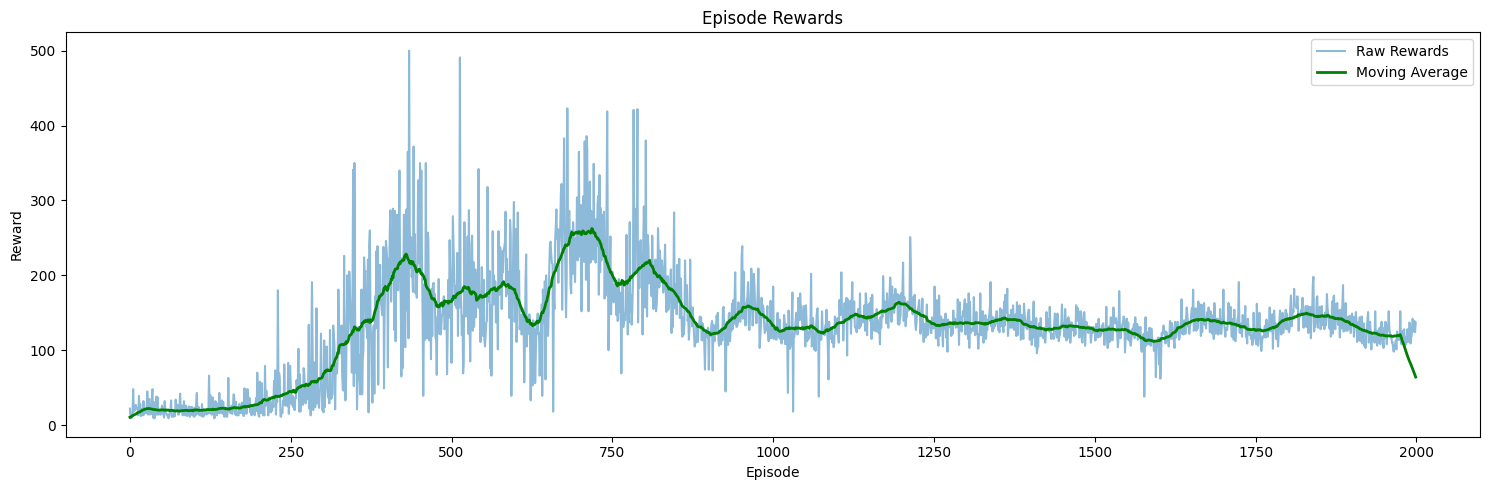

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


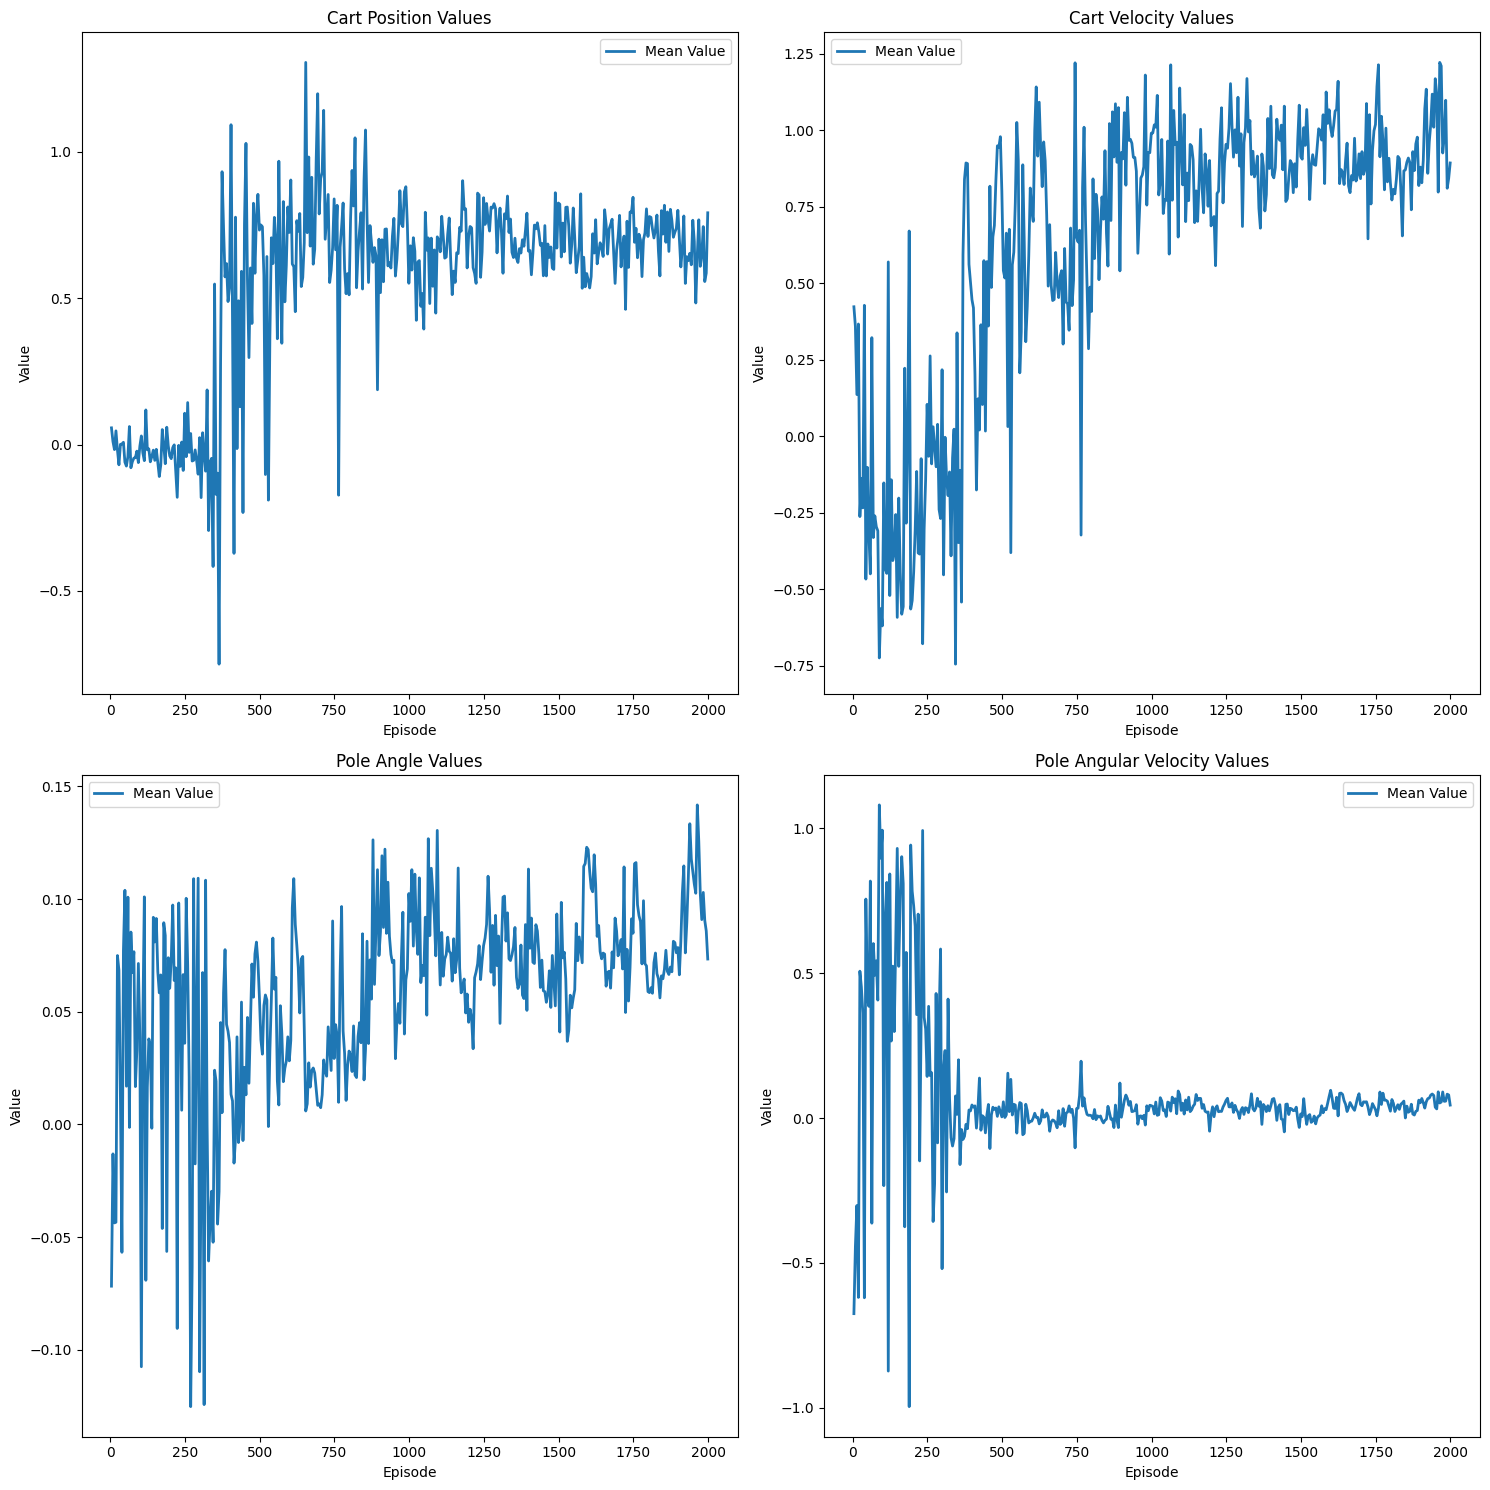

In [7]:
agent_without_batch = train_ppo_without_batch(ENV_NAME, EPISODES)

## Training with mini batch

In [68]:
def train_ppo_with_batch(env_name='CartPole-v1', episodes=1000, num_epochs=3, batch_size=64):
    env = gym.make(env_name)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = PPOAgent(state_dim, action_dim, lr=LR, clip_ratio=CLIP_EPS, value_loss_coef=VALUE_LOSS_COEFF, entropy_coef=ENTROPY_COEFF)

    episode_rewards = []
    episode_lengths = []

    all_state_values = {
        'cart_position': [],
        'cart_velocity': [],
        'pole_angle': [],
        'pole_angular_velocity': [],
    }

    all_states = []
    all_actions = []
    all_rewards = []
    all_dones = []
    all_log_probs = []
    all_values = []
    all_returns = []
    all_advantages = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        total_reward = 0
        step_count = 0

        episode_states = []
        episode_actions = []
        episode_rewards_episode = []
        episode_dones = []
        episode_log_probs = []
        episode_values = []

        episode_state_values = {
            'cart_position': [],
            'cart_velocity': [],
            'pole_angle': [],
            'pole_angular_velocity': [],
        }

        while not (done or truncated):
            step_count += 1
            episode_states.append(state)

            if (episode + 1) % 5 == 0:
                episode_state_values['cart_position'].append(state[0])
                episode_state_values['cart_velocity'].append(state[1])
                episode_state_values['pole_angle'].append(state[2])
                episode_state_values['pole_angular_velocity'].append(state[3])

            action, action_probs = agent.select_action(state)

            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            value = agent.value_network(state_tensor).item()

            next_state, reward, done, truncated, _ = env.step(action)

            episode_actions.append(action)
            episode_rewards_episode.append(reward)
            episode_dones.append(done or truncated)
            episode_log_probs.append(np.log(action_probs[action]))
            episode_values.append(value)

            total_reward += reward
            state = next_state

        for key in episode_state_values:
            all_state_values[key].append(episode_state_values[key])

        episode_values.append(0)

        returns = agent.compute_returns(episode_rewards_episode, episode_dones, episode_values, gamma=GAMMA, gae_lambda=LAMDA)
        advantages = returns - torch.tensor(episode_values[:-1])

        all_states.extend(episode_states)
        all_actions.extend(episode_actions)
        all_rewards.extend(episode_rewards_episode)
        all_dones.extend(episode_dones)
        all_log_probs.extend(episode_log_probs)
        all_values.extend(episode_values[:-1])
        all_returns.extend(returns.numpy())
        all_advantages.extend(advantages.numpy())

        episode_rewards.append(total_reward)
        episode_lengths.append(step_count)

        if len(all_states) >= batch_size:
            for _ in range(num_epochs):
                indices = np.random.permutation(len(all_states))
                for start in range(0, len(all_states), batch_size):
                    batch_indices = indices[start:start+batch_size]

                    batch_states = [all_states[i] for i in batch_indices]
                    batch_actions = [all_actions[i] for i in batch_indices]
                    batch_log_probs = [all_log_probs[i] for i in batch_indices]
                    batch_returns = torch.tensor(all_returns)[batch_indices]
                    batch_advantages = torch.tensor(all_advantages)[batch_indices]

                    # Perform update on this batch
                    agent.update(batch_states, batch_actions, batch_log_probs, batch_returns, batch_advantages)

            all_states.clear()
            all_actions.clear()
            all_rewards.clear()
            all_dones.clear()
            all_log_probs.clear()
            all_values.clear()
            all_returns.clear()
            all_advantages.clear()

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}, Episode Reward: {total_reward}, Avg Reward: {np.mean(episode_rewards[-10:]):.2f}")

    def compute_moving_average(data, window=5):
      return pd.Series(data).rolling(window, min_periods=1, center=True).mean().to_numpy()

    plt.figure(figsize=(15, 5))
    plt.plot(episode_rewards, label='Raw Rewards', alpha=0.5)

    moving_avg_rewards = compute_moving_average(episode_rewards)
    plt.plot(moving_avg_rewards, label='Moving Average', color='green', linewidth=2)

    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()

    state_labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
    state_keys = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']

    plt.figure(figsize=(15, 15))

    for i, (key, label) in enumerate(zip(state_keys, state_labels), 1):
        plt.subplot(2, 2, i)

        mean_values = [
            np.mean(episode_values)
            for episode_values in all_state_values[key]
            if episode_values
        ]

        episodes_with_data = [
            i for i, episode_values in enumerate(all_state_values[key])
            if episode_values
        ]

        plt.plot(episodes_with_data, mean_values, label='Mean Value', linewidth=2)

        plt.title(f'{label} Values')
        plt.xlabel('Episode')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

    return agent

## Training with Clipping Epsilon 0.1

In [72]:
GAMMA = 0.99
LAMDA = 0.95
CLIP_EPS = 0.1
ENTROPY_COEFF = 0.01
VALUE_LOSS_COEFF = 0.5
LR = 3e-4
ENV_NAME = "CartPole-v1"
EPISODES = 2000
BATCH_SIZE = 64
EPOCHS = 3

Using device: cpu
Episode 100, Episode Reward: 96.0, Avg Reward: 45.90
Episode 200, Episode Reward: 500.0, Avg Reward: 222.70
Episode 300, Episode Reward: 129.0, Avg Reward: 168.00
Episode 400, Episode Reward: 500.0, Avg Reward: 495.80
Episode 500, Episode Reward: 500.0, Avg Reward: 500.00
Episode 600, Episode Reward: 361.0, Avg Reward: 242.90
Episode 700, Episode Reward: 500.0, Avg Reward: 500.00
Episode 800, Episode Reward: 500.0, Avg Reward: 500.00
Episode 900, Episode Reward: 500.0, Avg Reward: 462.60
Episode 1000, Episode Reward: 414.0, Avg Reward: 434.70
Episode 1100, Episode Reward: 500.0, Avg Reward: 477.20
Episode 1200, Episode Reward: 500.0, Avg Reward: 479.10
Episode 1300, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1400, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1500, Episode Reward: 500.0, Avg Reward: 436.80
Episode 1600, Episode Reward: 261.0, Avg Reward: 476.10
Episode 1700, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1800, Episode Reward: 500.0, Avg 

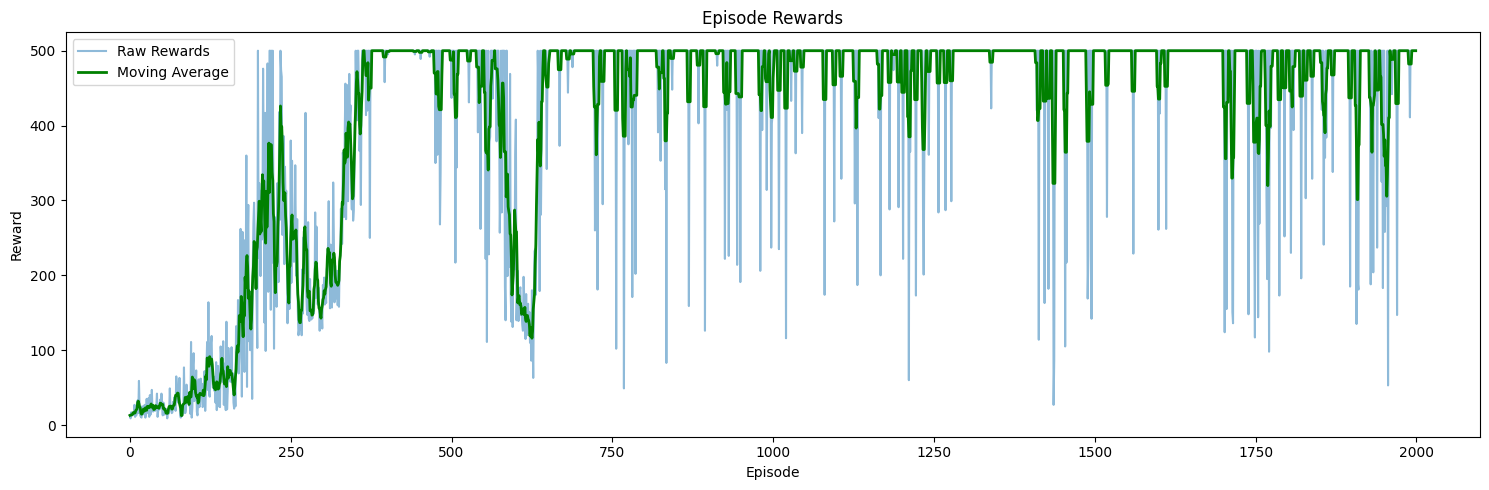

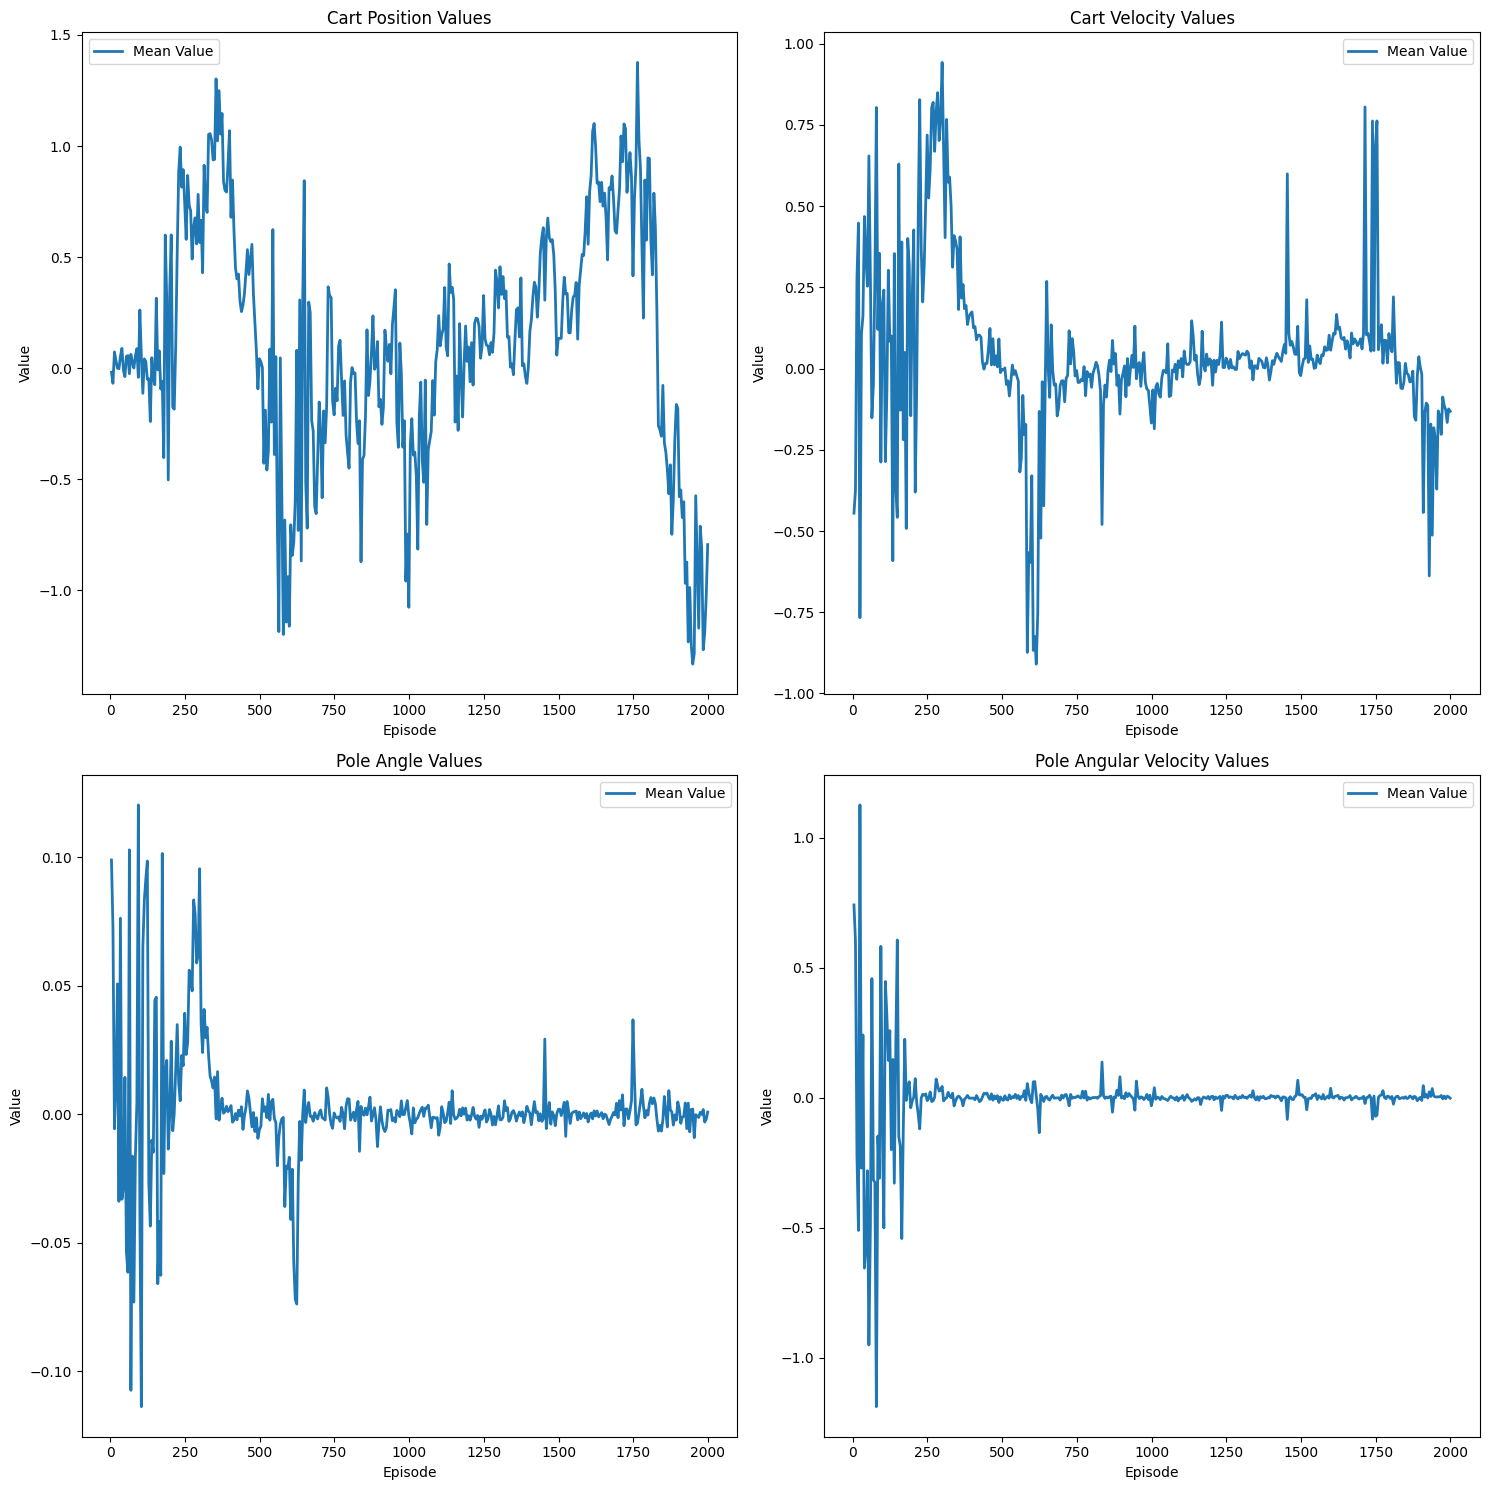

In [73]:
agent_with_batch = train_ppo_with_batch(ENV_NAME, EPISODES, batch_size=BATCH_SIZE, num_epochs=EPOCHS)

## Training with Clipping Epsilon 0.2

In [66]:
GAMMA = 0.99
LAMDA = 0.95
CLIP_EPS = 0.2
ENTROPY_COEFF = 0.01
VALUE_LOSS_COEFF = 0.5
LR = 3e-4
ENV_NAME = "CartPole-v1"
EPISODES = 2000
BATCH_SIZE = 64
EPOCHS = 3

Using device: cpu
Episode 100, Episode Reward: 45.0, Avg Reward: 35.00
Episode 200, Episode Reward: 210.0, Avg Reward: 187.00
Episode 300, Episode Reward: 488.0, Avg Reward: 370.70
Episode 400, Episode Reward: 500.0, Avg Reward: 476.50
Episode 500, Episode Reward: 500.0, Avg Reward: 500.00
Episode 600, Episode Reward: 388.0, Avg Reward: 457.90
Episode 700, Episode Reward: 500.0, Avg Reward: 429.00
Episode 800, Episode Reward: 500.0, Avg Reward: 478.10
Episode 900, Episode Reward: 269.0, Avg Reward: 470.50
Episode 1000, Episode Reward: 500.0, Avg Reward: 493.00
Episode 1100, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1200, Episode Reward: 500.0, Avg Reward: 465.10
Episode 1300, Episode Reward: 500.0, Avg Reward: 478.30
Episode 1400, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1500, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1600, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1700, Episode Reward: 475.0, Avg Reward: 493.50
Episode 1800, Episode Reward: 500.0, Avg 

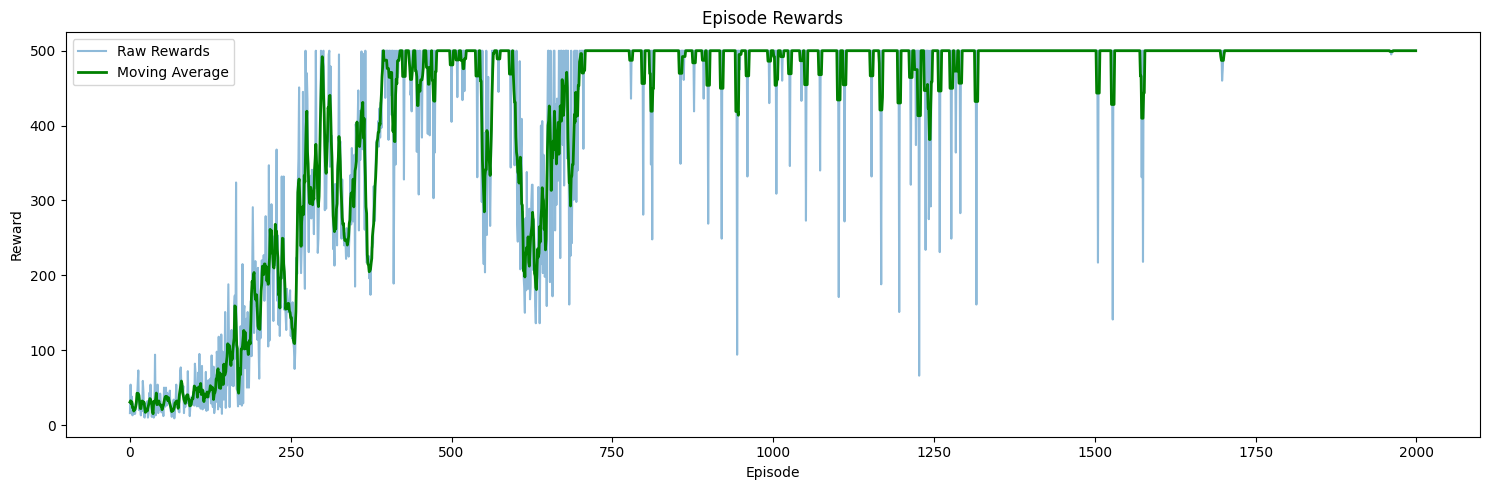

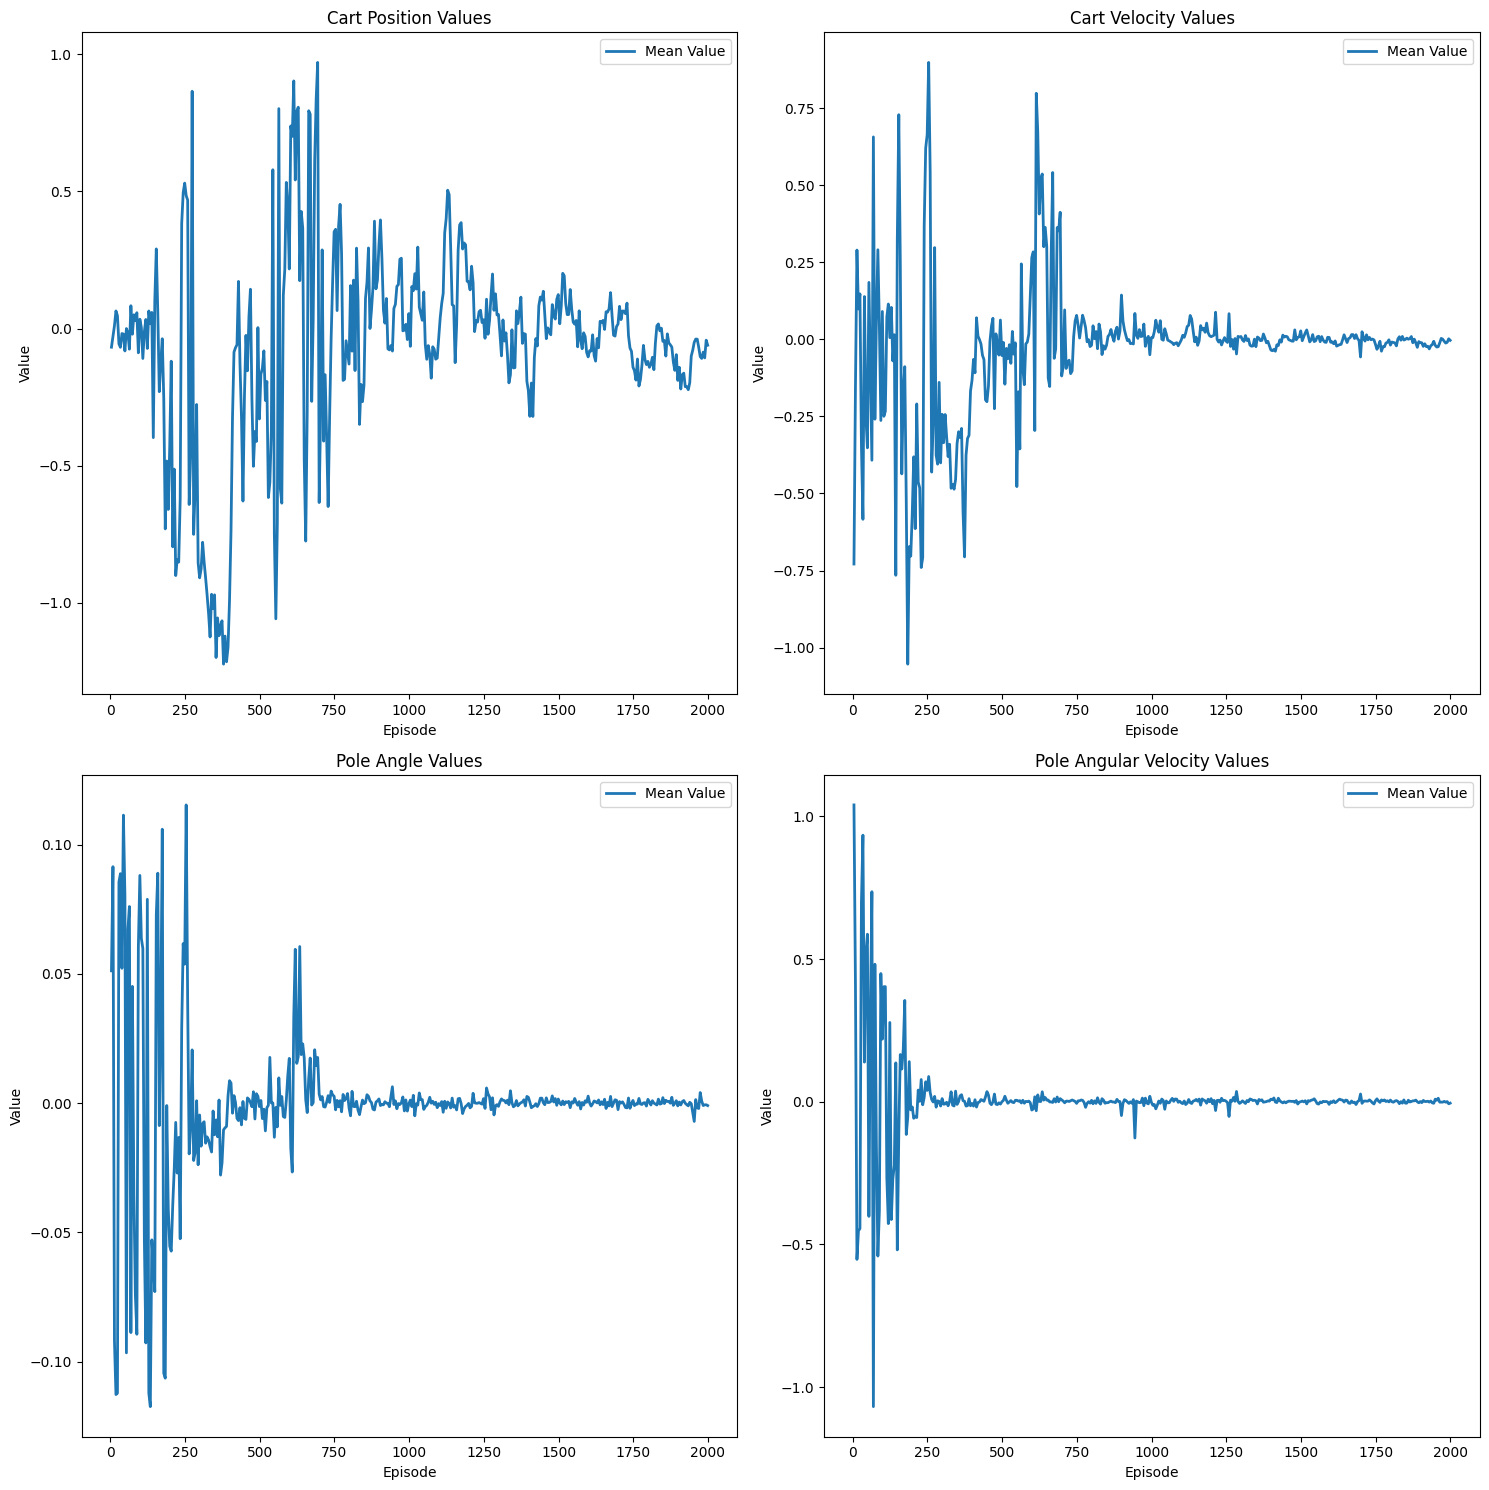

In [69]:
agent_with_batch = train_ppo_with_batch(ENV_NAME, EPISODES, batch_size=BATCH_SIZE, num_epochs=EPOCHS)

## Training with Clipping Epsilon 0.3

In [77]:
GAMMA = 0.99
LAMDA = 0.95
CLIP_EPS = 0.3
ENTROPY_COEFF = 0.01
VALUE_LOSS_COEFF = 0.5
LR = 3e-4
ENV_NAME = "CartPole-v1"
EPISODES = 2000
BATCH_SIZE = 64
EPOCHS = 3

Using device: cpu
Episode 100, Episode Reward: 29.0, Avg Reward: 32.80
Episode 200, Episode Reward: 183.0, Avg Reward: 240.80
Episode 300, Episode Reward: 167.0, Avg Reward: 123.60
Episode 400, Episode Reward: 500.0, Avg Reward: 500.00
Episode 500, Episode Reward: 500.0, Avg Reward: 500.00
Episode 600, Episode Reward: 500.0, Avg Reward: 493.10
Episode 700, Episode Reward: 500.0, Avg Reward: 500.00
Episode 800, Episode Reward: 94.0, Avg Reward: 113.30
Episode 900, Episode Reward: 500.0, Avg Reward: 472.10
Episode 1000, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1100, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1200, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1300, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1400, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1500, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1600, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1700, Episode Reward: 500.0, Avg Reward: 500.00
Episode 1800, Episode Reward: 500.0, Avg R

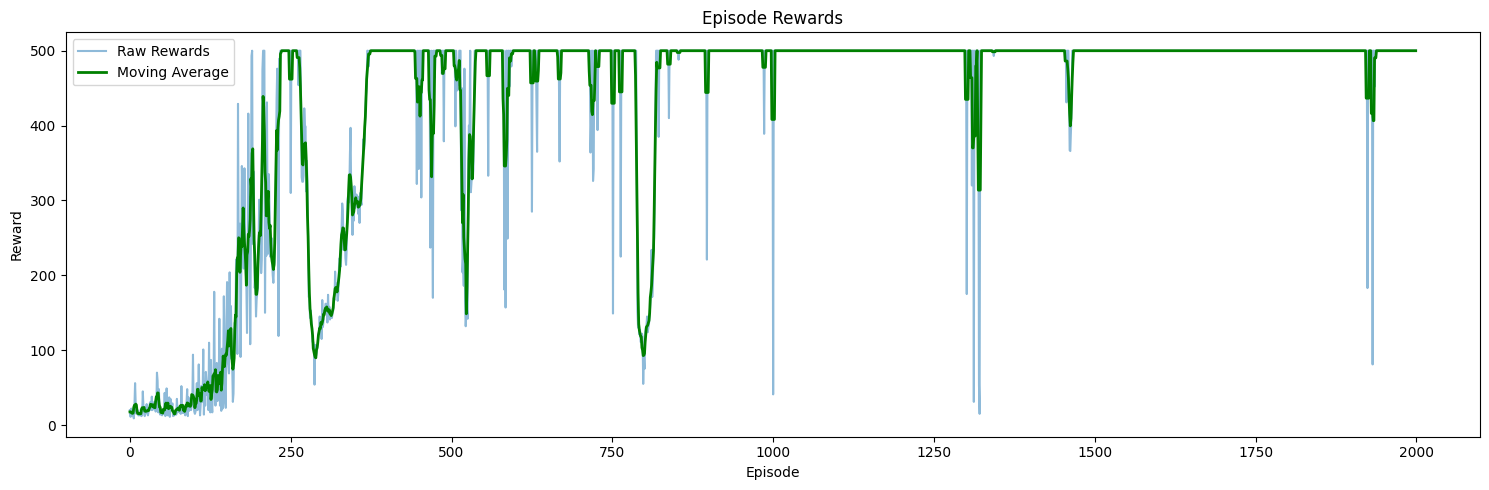

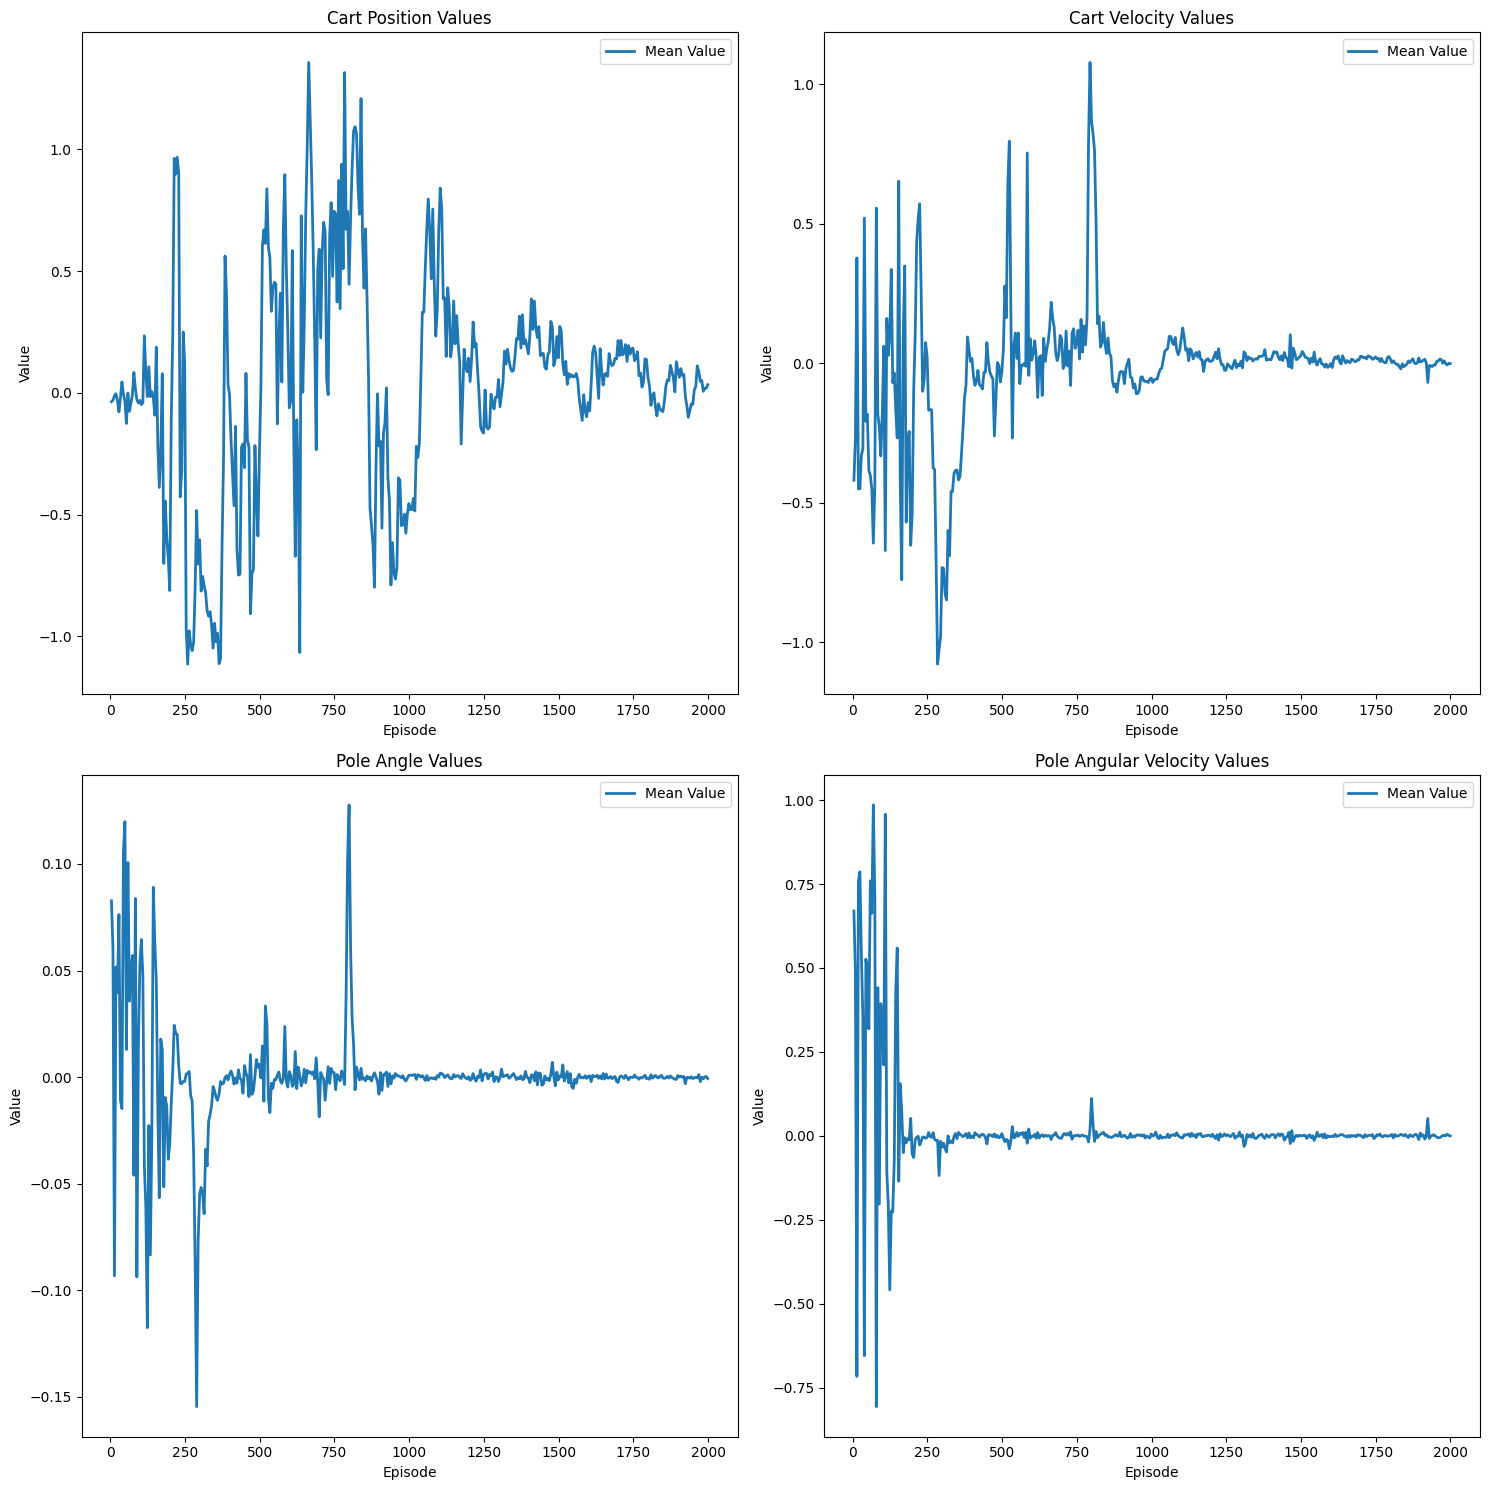

In [78]:
agent_with_batch = train_ppo_with_batch(ENV_NAME, EPISODES, batch_size=BATCH_SIZE, num_epochs=EPOCHS)

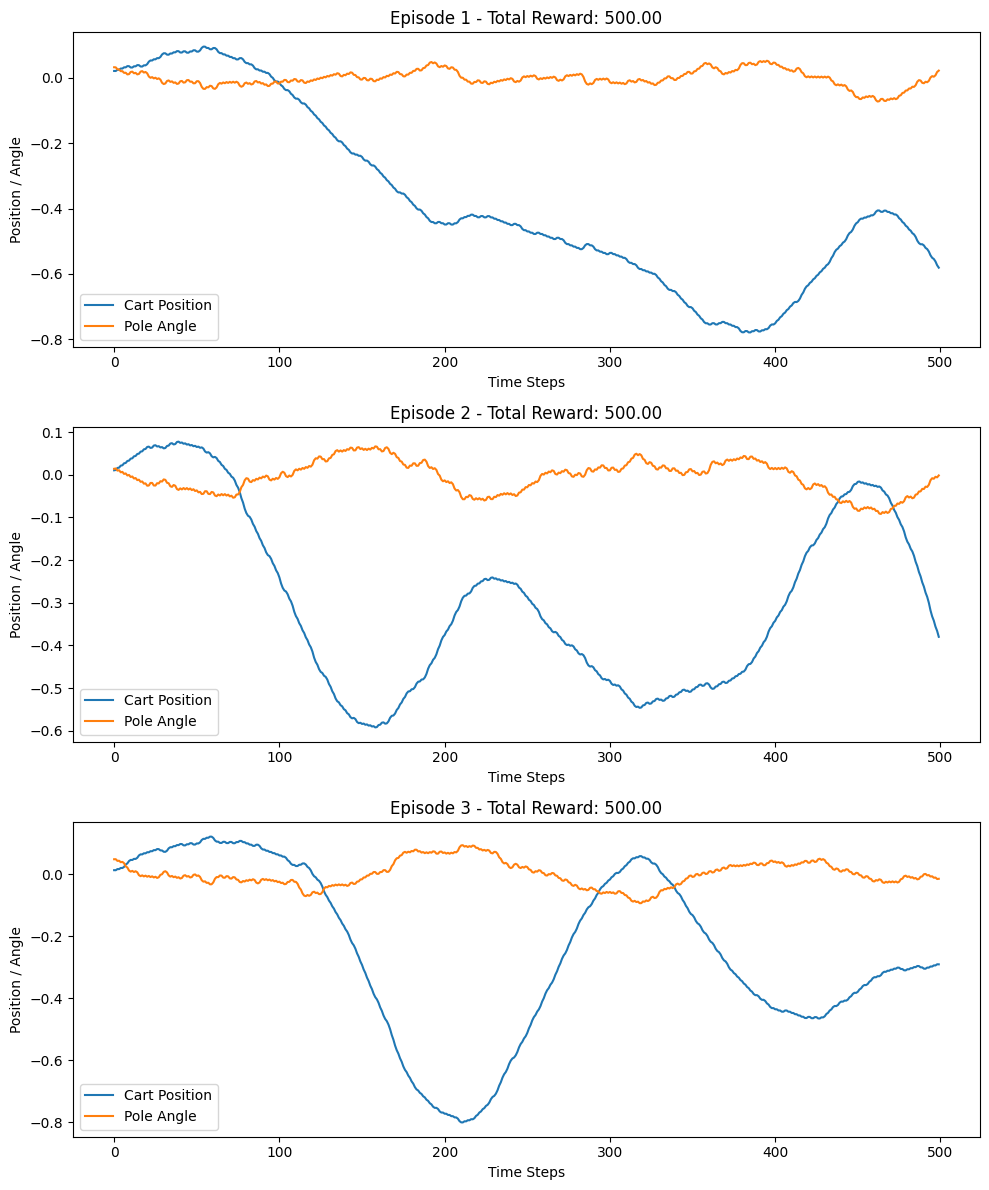

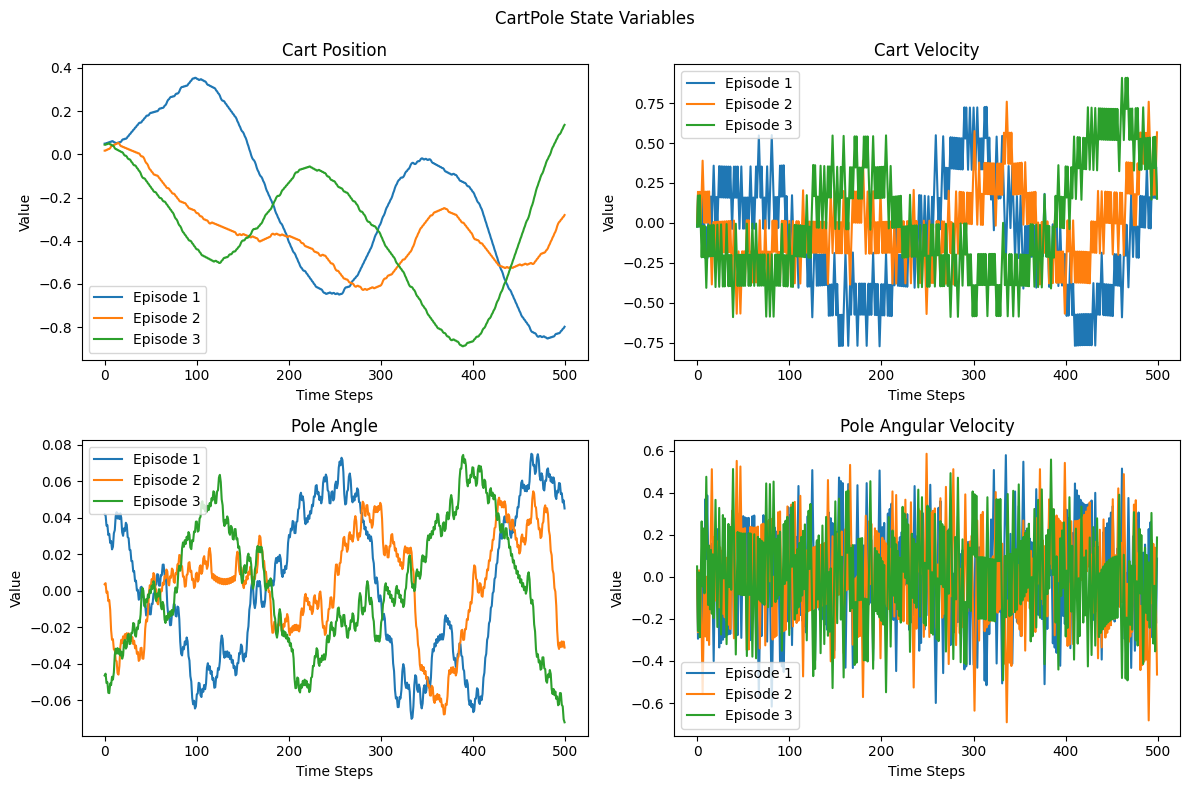

In [24]:
visualize_cartpole(agent)
visualize_cartpole_states(agent)